In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, SLSQP
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
import collections
algorithm_globals.random_seed = 12345

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

x_train, y_train = filter_01(X_train, y_train)
x_test, y_test = filter_01(X_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


x_train_flatten = x_train.reshape(-1, 28 * 28) / 255.0  
x_test_flatten = x_test.reshape(-1, 28 * 28) / 255.0

print(x_train_flatten[0].shape)

Number of filtered training examples: 12665
Number of filtered test examples: 2115
(784,)


In [3]:
num_components = 8 
pca = PCA(n_components=num_components)
x_train_pca = pca.fit_transform(x_train_flatten)
x_test_pca = pca.transform(x_test_flatten)
 
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(x_train_pca, y_train, test_size=0.3, random_state=42)
 
input_layer = Input(shape=(num_components,))
x = Dense(128, activation='relu')(input_layer)
output_layer = Dense(10, activation='softmax')(x)
 
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 

batch_size = 64
epochs = 20
history = model.fit(X_train_split, y_train_split, batch_size=batch_size, epochs=epochs, validation_data=(X_val_split, y_val_split))
 

model.save('8_01_pca_model.h5')
print("Model saved")
 

test_loss, test_accuracy = model.evaluate(x_test_pca, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

# loaded_model = tf.keras.models.load_model('8pca_model.h5')

# loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(X_test_pca, y_test, verbose=0)
# print(f'Loaded model test accuracy: {loaded_test_accuracy:.4f}')

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8764 - loss: 0.7079 - val_accuracy: 0.9982 - val_loss: 0.0275
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0236 - val_accuracy: 0.9989 - val_loss: 0.0116
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9979 - loss: 0.0120 - val_accuracy: 0.9989 - val_loss: 0.0073
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 0.9989 - val_loss: 0.0053
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9983 - loss: 0.0068 - val_accuracy: 0.9989 - val_loss: 0.0044
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9989 - val_loss: 0.0038
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9983 - loss: 0.0048 - val_accuracy: 0.

Model saved
Test accuracy: 0.9991


In [4]:
num_samples = 50
def select_samples(x, y, num_samples_per_class=num_samples):
    # Create lists to hold selected samples
    selected_x = []
    selected_y = []
    
    # Get unique classes
    classes = np.unique(y)
    
    for cls in classes:
        # Find indices of the current class
        class_indices = np.where(y == cls)[0]
        if len(class_indices) > 0:
            # Randomly select indices
            selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
            selected_x.append(x[selected_indices])
            selected_y.append(y[selected_indices])
    
    # Concatenate the selected samples
    selected_x = np.concatenate(selected_x)
    selected_y = np.concatenate(selected_y)
    
    return selected_x, selected_y

x_train_sub, y_train_sub = select_samples(x_train_pca, y_train)
x_test_sub, y_test_sub = select_samples(x_test_pca, y_test, int(num_samples*0.4))

# 打乱数据和标签
train_indices = np.random.permutation(x_train_sub.shape[0])
x_train_shuffled = x_train_sub[train_indices]
y_train_shuffled = y_train_sub[train_indices]

test_indices = np.random.permutation(x_test_sub.shape[0])
x_test_shuffled = x_test_sub[test_indices]
y_test_shuffled = y_test_sub[test_indices]

y_train_spin = np.where(y_train_shuffled, 1, -1)
y_test_spin = np.where(y_test_shuffled, 1, -1)

In [5]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

def owneout_layer(sources, sinks):
    num_qubits = len(sources) + len(sinks)
    nn = len(sinks)
    qc = QuantumCircuit(num_qubits, name="Oneout Layer")
    print(num_qubits)
    for i in range(nn - 1): 
        qc.cx(sinks[i], sinks[i + 1])
    
    # 对最后一个量子比特应用 Hadamard 门
    # qc.h(sinks[-1])
    
    return qc


In [6]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# ansatz.compose(owneout_layer([0, 1, 2, 3], [4, 5, 6, 7]), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    # estimator=backend,
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

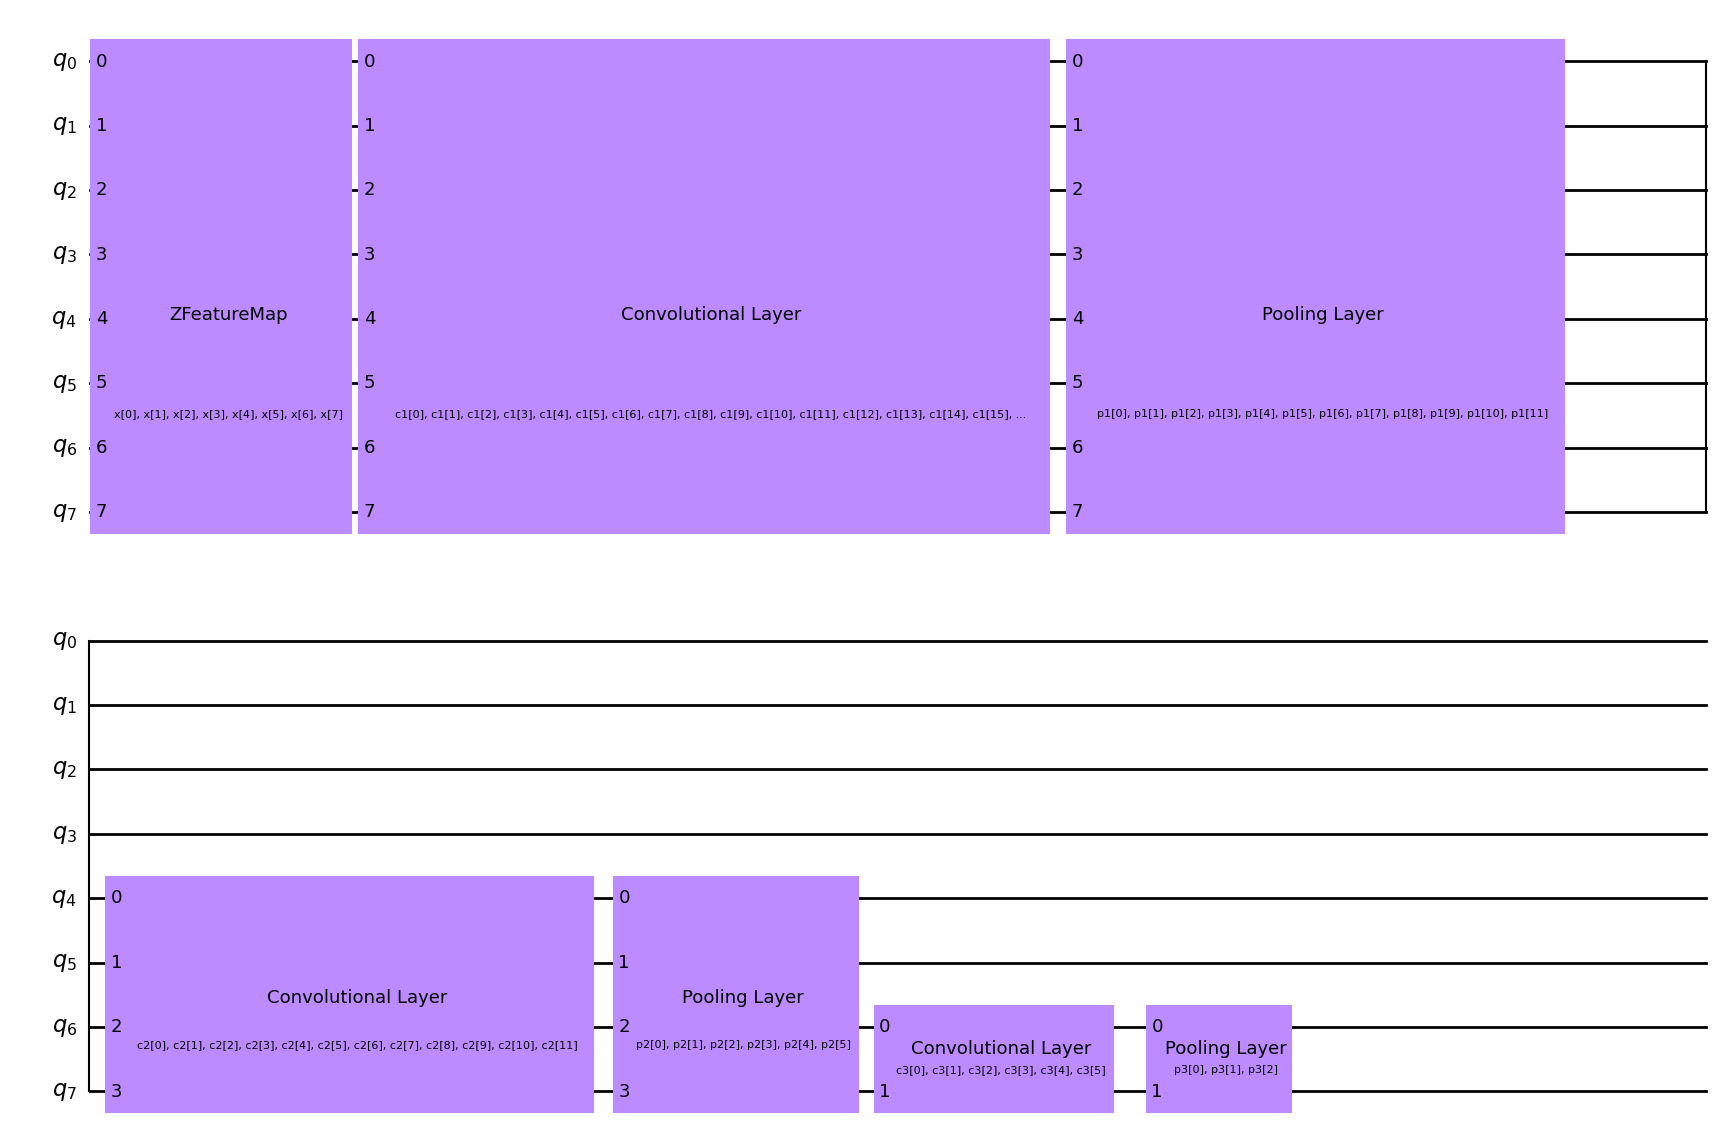

In [7]:
circuit.draw("mpl", style="clifford")

In [8]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

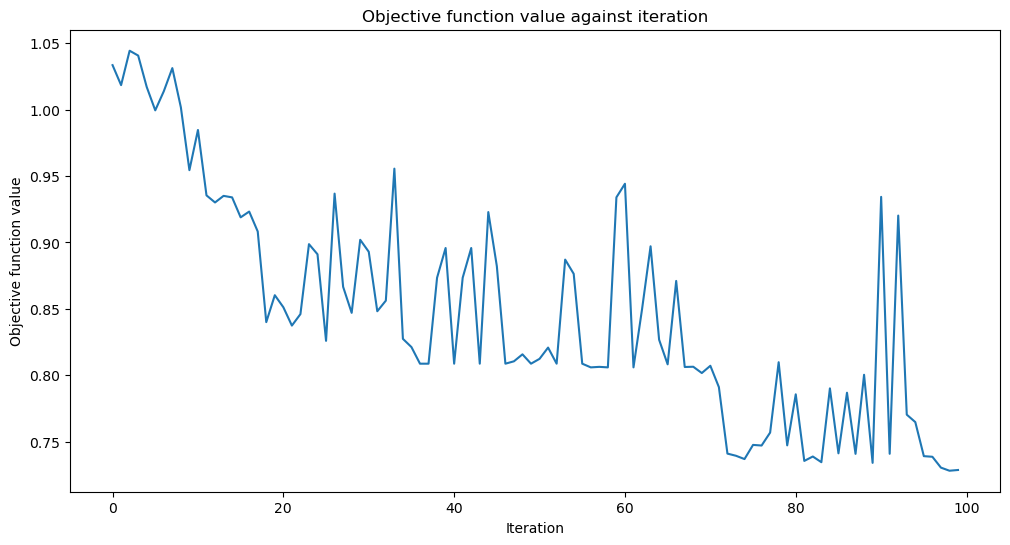

Accuracy from the train data : 73.0%


In [9]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  
    callback=callback_graph
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_spin)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [10]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_spin)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 80.0%


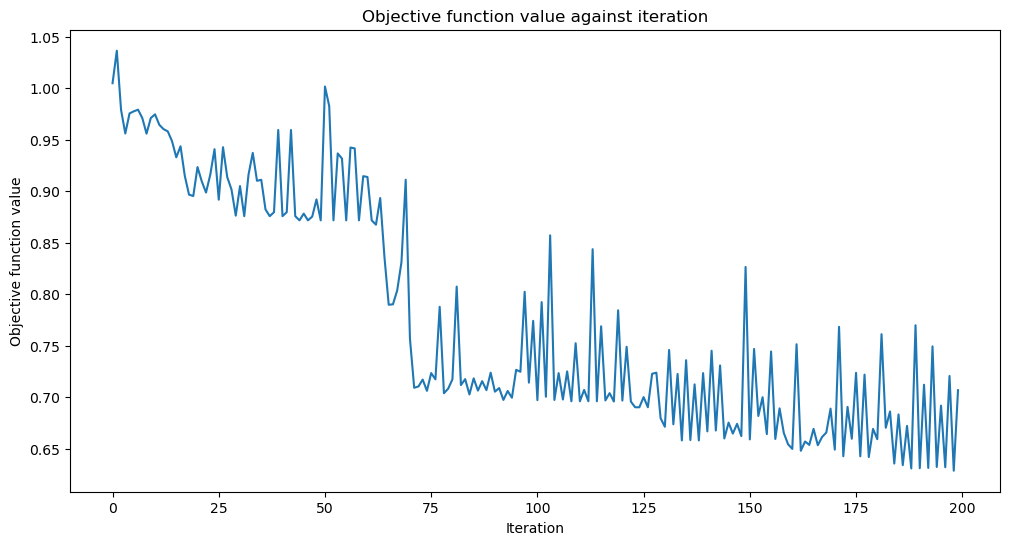

Accuracy from the train data : 73.0%


In [11]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  
    callback=callback_graph
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_spin)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [12]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_spin)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 75.0%


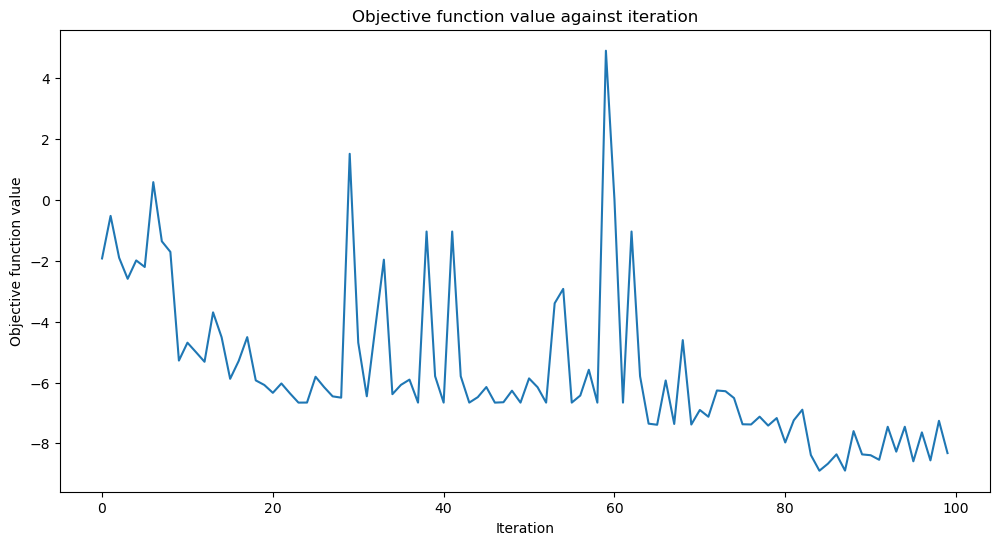

Accuracy from the train data : 79.0%
Accuracy from the test data : 77.5%


In [13]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=COBYLA(maxiter=100),  
    callback=callback_graph
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_spin)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_spin)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

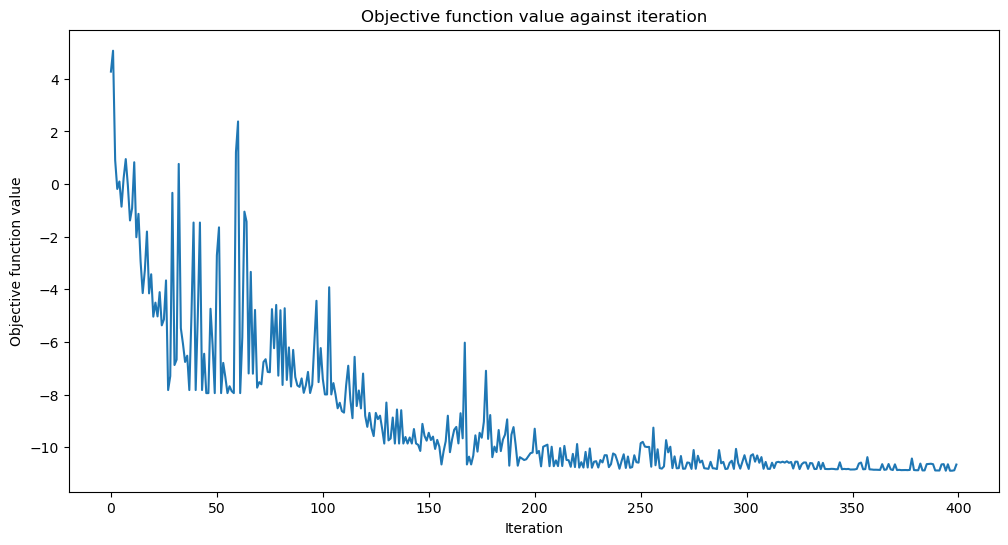

Accuracy from the train data : 87.0%
Accuracy from the test data : 65.0%


In [14]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=COBYLA(maxiter=400),  
    callback=callback_graph
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_spin)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_spin)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

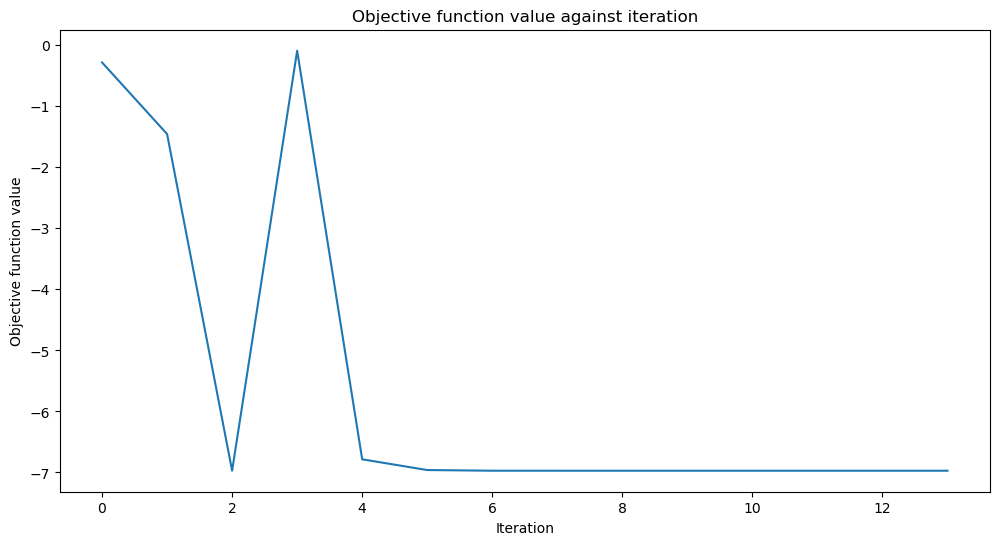

Accuracy from the train data : 73.0%
Accuracy from the test data : 70.0%


In [16]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=SLSQP(maxiter=100),  
    callback=callback_graph
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_spin)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_spin)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

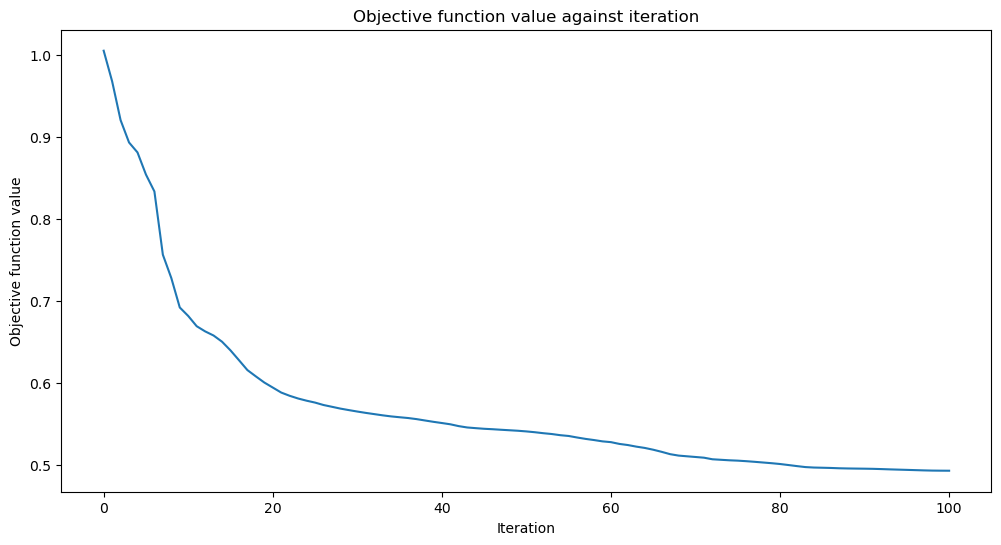

Accuracy from the train data : 85.0%
Accuracy from the test data : 80.0%


In [17]:
classifier = NeuralNetworkClassifier(
    qnn,
    # loss='cross_entropy',
    optimizer=SLSQP(maxiter=100),  
    callback=callback_graph
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_spin)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_spin)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

In [97]:
classifier.save(file_name="pca_spin_original_500_7417ac")

In [99]:
from sklearn.metrics import confusion_matrix
# y_pred = model.predict(x_test)
cm = confusion_matrix(y_test_spin, y_predict)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[24  0]
 [12 12]]
